In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from collections import defaultdict
from crystallus import pbc_all_distances, CrystalGenerator, WyckoffCfgGenerator
from pymatgen import Structure
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

## Test case: `Ag32Ge4S24`.

* Spacegroup 33
* Wyckoff positions:
    (x,y,z) (-x,-y,z+1/2) (x+1/2,-y+1/2,z) (-x+1/2,y+1/2,z+1/2)
* Ground truth:
    {Ag: 4a \* 8, Ge: 4a, S: 4a \* 5}

In [2]:
wg = WyckoffCfgGenerator(Ag=32, Ge=4, S=24)
wg

WyckoffCfgGenerator(            
    max_recurrent=1000,            
    n_jobs=-1            
    composition={'Ag': 32, 'Ge': 4, 'S': 24}            
)

In [3]:
cfgs = wg.gen_many(1000, 33)
cfgs

[{'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
  'Ge': ['a'],
  'S': ['a', 'a', 'a', 'a', 'a', 'a']}]

Please note that space group 33 only has one Wyckoff position set.

In [4]:
cg = CrystalGenerator(
    spacegroup_num=33,
    estimated_volume=1168.454590,
    estimated_variance=15,
    verbose=False,
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    estimated_volume=1168.45459,            
    estimated_variance=15,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    n_jobs=-1            
)

### Test the most strict case

In [5]:
%%time

expect_size = 100_000_000
results = []
ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=0)
len(ret)

### Calculate the `distance_scale_factor` dependency

In [6]:
%%time

expect_size = 500_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

In [6]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
results.to_pickle('results.pd.xz')
results.head(3)

,scale,proportion,S-S,S-Ge,S-Ag,Ge-Ge,Ge-Ag,Ag-Ag
0,0.20,0.0,1.6320,1.760,1.9360,1.8880,2.0640,2.240
1,0.22,0.0,1.5912,1.716,1.8876,1.8408,2.0124,2.184
2,0.24,0.0,1.5504,1.672,1.8392,1.7936,1.9608,2.128


(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

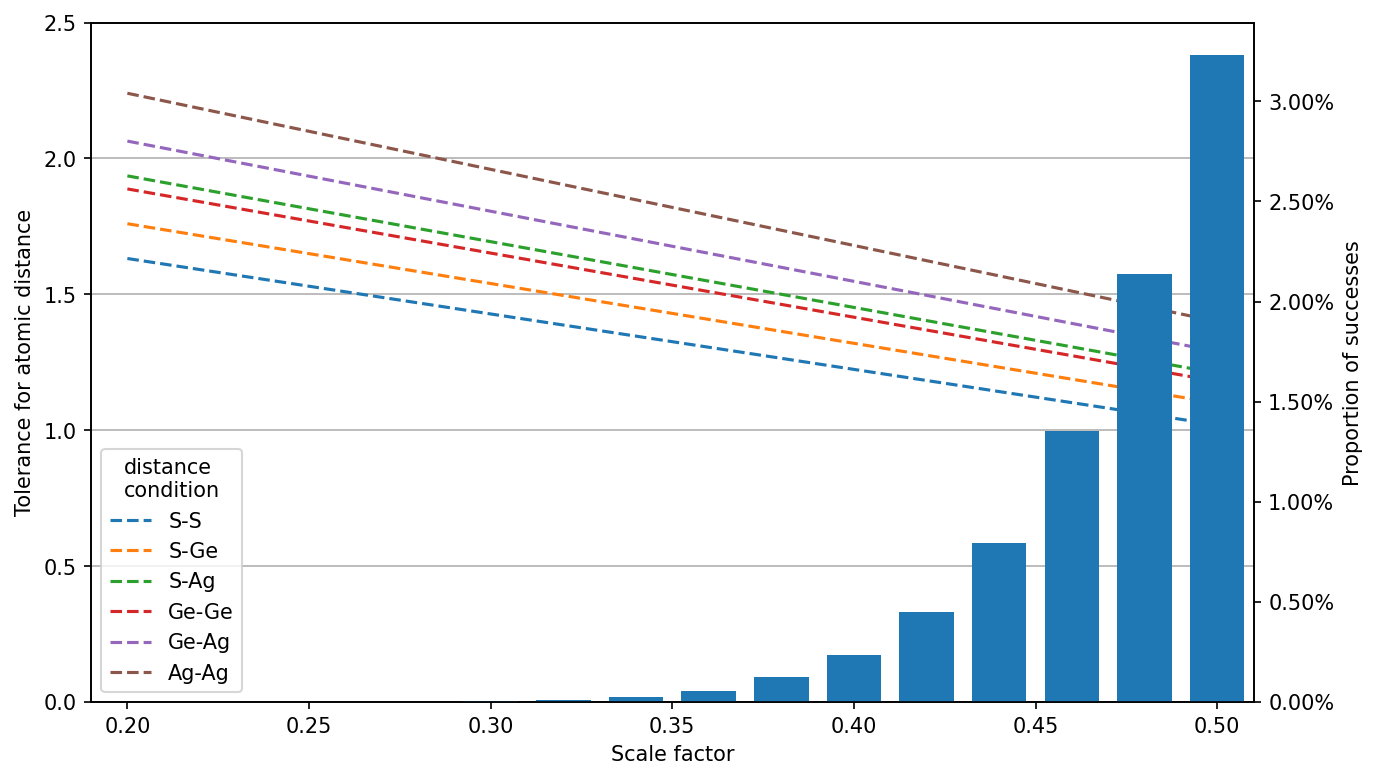

In [46]:
from matplotlib.ticker import FormatStrFormatter, PercentFormatter

f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)